# **Imports**

In [35]:
import pandas as pd
import ydata_profiling as pp
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Problem**
Predict the average price of apples for the following week

In [36]:
file = 'apples.csv'
df = pd.read_csv(file)
df.dtypes

Unnamed: 0         int64
date              object
average_price    float64
total_volume       int64
gala               int64
fuji               int64
granny_smith       int64
total_bags         int64
s_bags             int64
l_bags             int64
xl_bags            int64
type              object
region            object
dtype: object

# 1.Data: Pre-process

In [37]:
##Pre-pre-process

#Removing what is not TotalUS
df = df[df['region'] == 'TotalUS'].copy()

#Casting date as datetime type
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date')

#Separating by conventional and organic
df_conv = df[df['type'] == 'conventional']
df_org = df[df['type'] == 'organic']

#Choosing columns of interest
columns_of_interest = ['date', 'average_price', 'total_volume', 'gala', 'fuji', 'granny_smith', 'total_bags', 's_bags', 'l_bags', 'xl_bags']
df_conv = df_conv[columns_of_interest]
df_org = df_org[columns_of_interest]
columns_of_interest.append('type')
df = df[columns_of_interest]

In [38]:
#Calender features
def calender_features(data):
    data['week'] = data['date'].dt.isocalendar().week
    data['week'] = data['week'].astype('int32')
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

calender_features(df)
calender_features(df_conv)
calender_features(df_org)


In [39]:
#plt.style.available

In [40]:
#Seaborn styles
#sns.set(style="whitegrid")
sns.set_palette("Set2")
plt.style.use('Solarize_Light2')

Data distribution by year

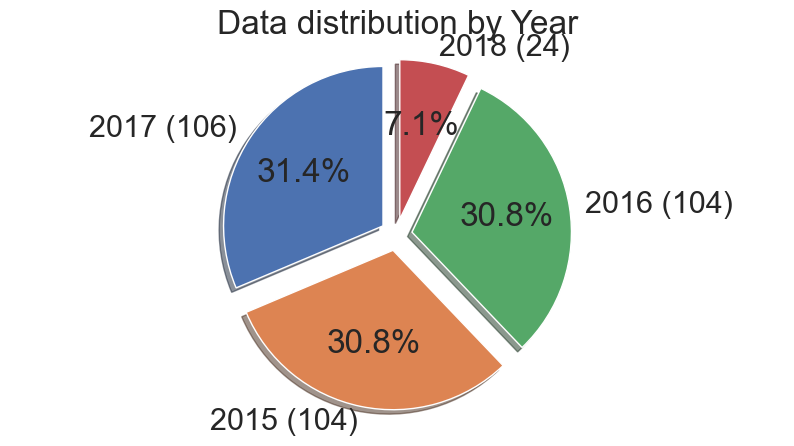

In [41]:
year_count = df["year"].value_counts()
sns.set(font_scale=2)

plt.figure(figsize=(10, 5))
plt.title("Data distribution by Year")

# Explode the slice with the highest count (optional)
explode = (0.1, 0.1, 0.1, 0.1)  # Adjust the values as needed

# Label formatting
labels = [f"{year} ({count})" for year, count in zip(year_count.index, year_count.values)]

plt.pie(year_count, labels=labels, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

plt.show()

Total volume by type

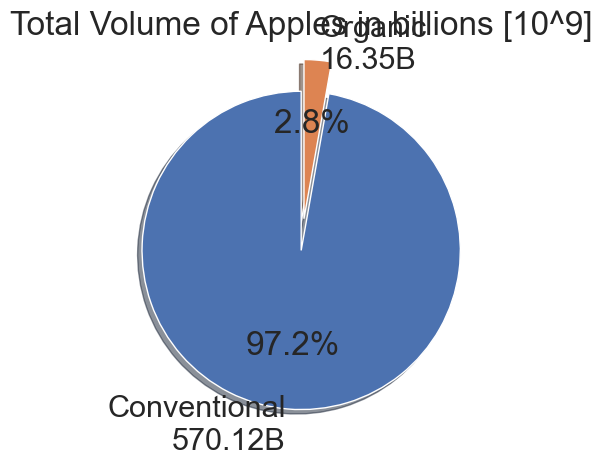

In [42]:
conv_totalV = df_conv['total_volume'].sum() / 1e9
orga_totalV = df_org['total_volume'].sum() / 1e9
values = [round(conv_totalV, 2), round(orga_totalV, 2)]
labels = ['Conventional', 'Organic']

sns.set(font_scale=2)
plt.figure(figsize=(5, 5))
plt.title('Total Volume of Apples in billions [10^9]')

# Explode a slice for emphasis (optional)
explode = (0.1, 0.1)

# Label formatting
labels_with_values = [f'{label}\n{value:.2f}B' for label, value in zip(labels, values)]

plt.pie(values, labels=labels_with_values, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

plt.show()


Conventional apples by cultivar

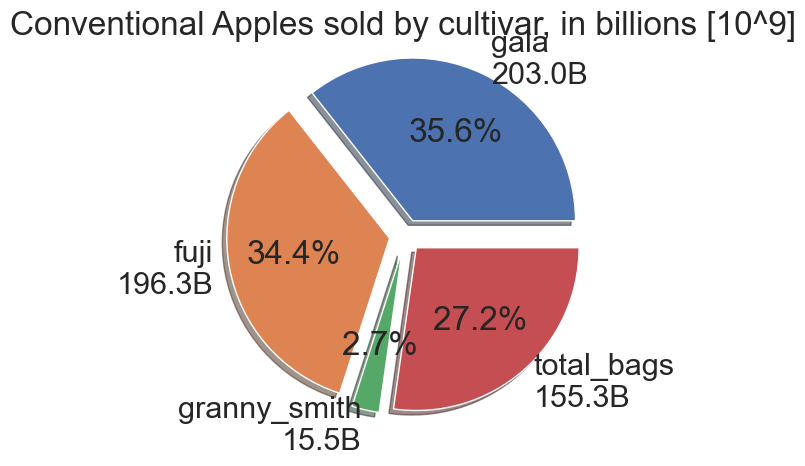

In [43]:
def pie_chart_per_apple_type(d, title):
    apple_type = ['gala', 'fuji', 'granny_smith', 'total_bags']
    values = [round(d[apple].sum() / 1e9, 1) for apple in apple_type]
    labels = [f'{label}\n{value:.1f}B' for label, value in zip(apple_type, values)]

    sns.set(font_scale=2)
    plt.figure(figsize=(5, 5))
    plt.title(title)

    # Explode slices for emphasis (optional)
    explode = (0.1, 0.1, 0.1, 0.1)  # Adjust values as needed

    plt.pie(values, labels=labels, autopct='%1.1f%%', explode=explode, shadow=True)
    plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

    plt.show()

pie_chart_per_apple_type(df_conv, 'Conventional Apples sold by cultivar, in billions [10^9]')


Price and volume analysis

1.65
0.76
2.09
1.0


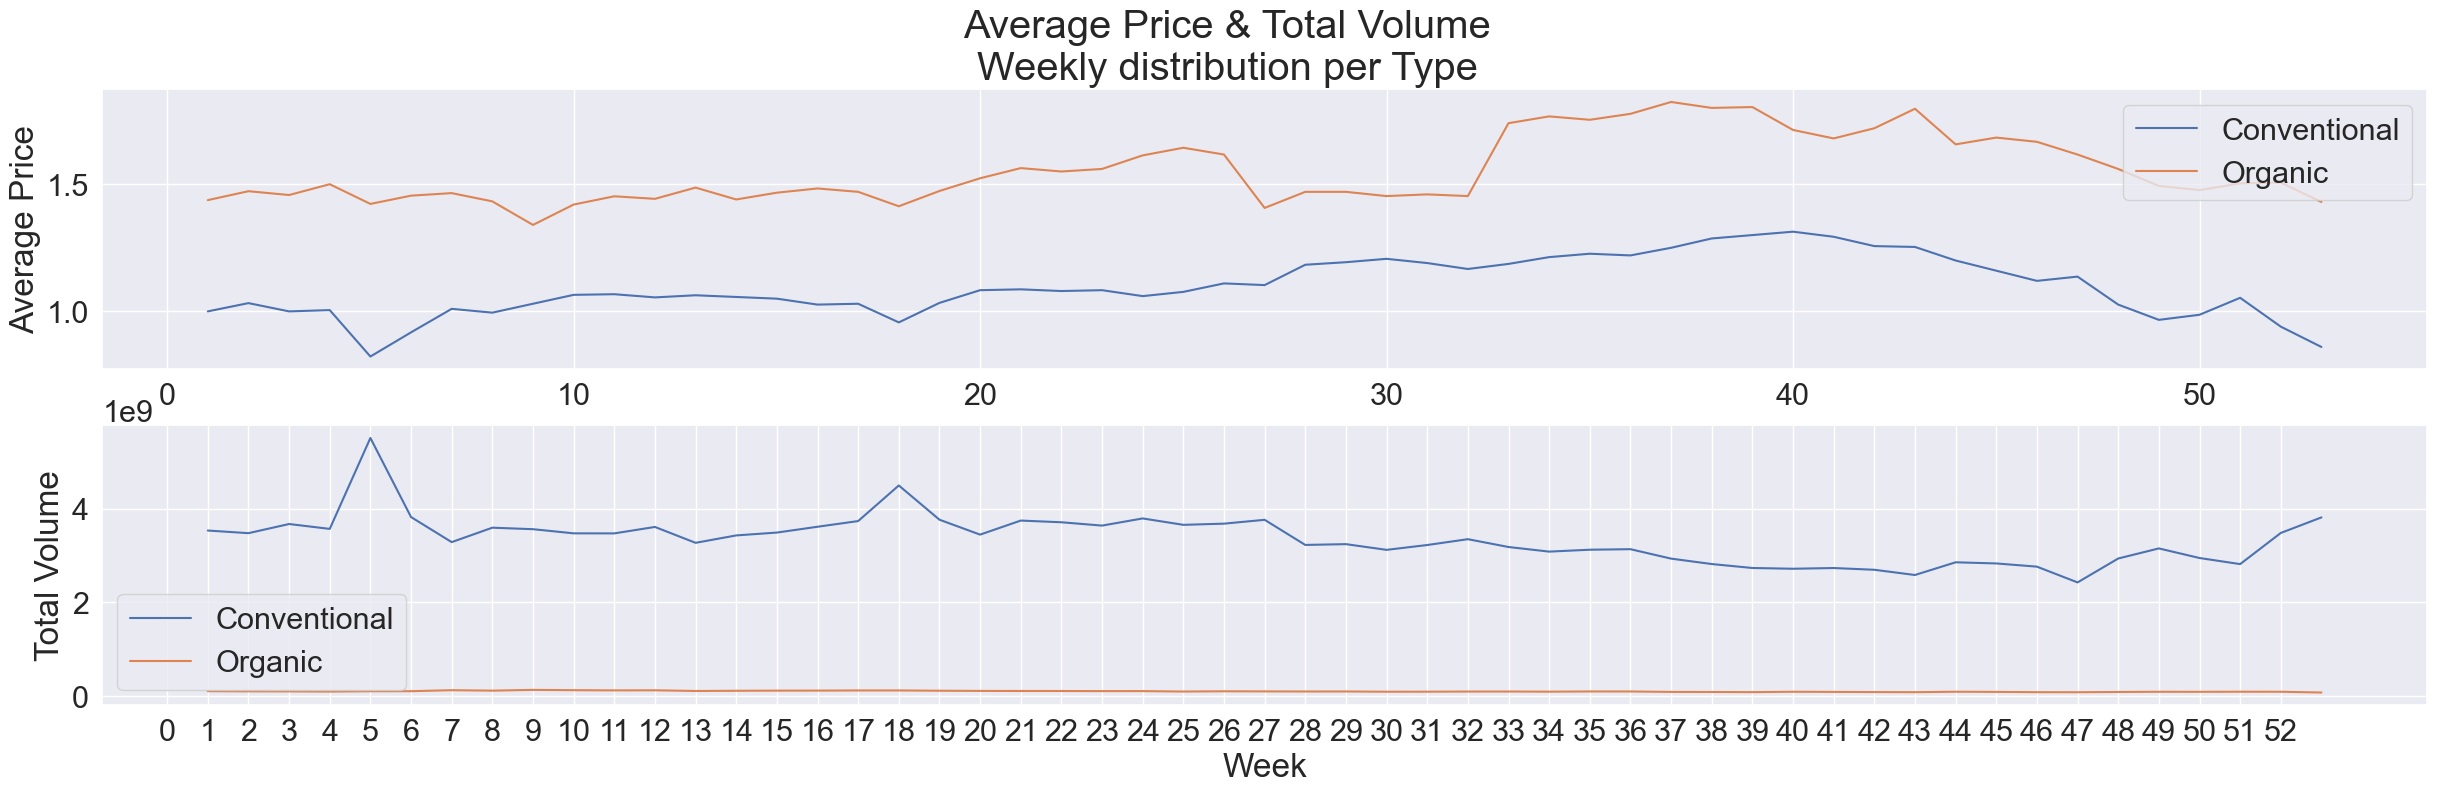

In [44]:
figure, ax = plt.subplots(2,1,figsize=(30,8))
listOf_Xticks = np.arange(0, 53, 1)
plt.xticks(listOf_Xticks)
figure.suptitle("Average Price & Total Volume\nWeekly distribution per Type")
plt.xlabel("Week")
ax[0].set_ylabel("Average Price")
ax[1].set_ylabel("Total Volume")

#Feature engineeering
df_org['week'] = df_org['date'].dt.isocalendar().week

#df_avg_price_conv = df[df['type']=='conventional']
#df_avg_price_org = df[df['type']=='organic']
df_avg_price_conv_week = df_conv['average_price'].groupby(df_conv['week']).mean()
df_avg_price_org_week =  df_org['average_price'].groupby(df_org['week']).mean()
df_volume_conv_week = df_conv['total_volume'].groupby(df_conv['week']).mean()
df_volume_org_week =  df_org['total_volume'].groupby(df_org['week']).mean()


ax[0].plot(df_avg_price_conv_week, label="Conventional")
ax[0].plot(df_avg_price_org_week, label="Organic")
ax[1].plot(df_volume_conv_week, label="Conventional")
ax[1].plot(df_volume_org_week, label="Organic")
ax[0].legend()
ax[1].legend()

print(df_conv['average_price'].max())
print(df_conv['average_price'].min())
print(df_org['average_price'].max())
print(df_org['average_price'].min())

Convencional e organico (avg_price) por mes e ano

# **Model**

In [47]:
df_conv['target'] = df_conv['average_price'].shift(-1)
df_conv = df_conv.loc[df_conv['target'].notna()].copy().reset_index(drop = True)

split_date = pd.to_datetime('2018-01-01')

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

def print_stats(df_set, df):
    print(f'Percentage of original: {len(df_set) / len(df):.0%}')
    print('Target min: {}'.format(df_set["target"].min()))
    print(f'Target median:\t{df_set["target"].median():,.2f}')
    print(f'Target mean:\t{df_set["target"].mean():,.2f}')
    print(f'Target max:\t{df_set["target"].max():,.2f}')

print('\nFull train')
print_stats(df_conv_train, df_conv)
print('\nTest')
print_stats(df_conv_test, df_conv)


Full train
Percentage of original: 93%
Target min: 0.76
Target median:	1.04
Target mean:	1.10
Target max:	1.65

Test
Percentage of original: 7%
Target min: 0.87
Target median:	1.07
Target mean:	1.05
Target max:	1.20


Gradient descent regressor

In [66]:
from xgboost import XGBRegressor

#Hyper-parameters
algo_params = {
    'max_depth': 6, #tree-depth
    'n_estimators': 80, #number of trees
}
algo_params['seed'] = 123 
algo_params['n_jobs'] = -1 #PC config to use all local clusters
algo_params['tree_method'] = 'hist' #histogram-based method for faster training
algo_params['use_label_encoder'] = False #No label encoding for categorical features

#Create instance of regression model with the params
model = XGBRegressor(**algo_params)  #**: dic key-value pairs as keyword args to the constructor 
                                     #-> same thing as explicitly writing each h-param in the function

#### features used
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    #'RM_avgP_M',
    #'week',
    #'month',
    #'year',
    #'price_elasticity',
]

model.fit( #Training the model
    df_conv_train[numeric_features_used],
    df_conv_train['target']
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

Evaluating the model

In [67]:
from sklearn.metrics import mean_squared_error

def print_score(model, train, test, features):
    preds_train = model.predict(train[features])
    rmse_train = mean_squared_error(train['target'], preds_train, squared = False)

    preds_test = model.predict(test[features])
    rmse_test = mean_squared_error(test['target'], preds_test, squared = False)

    overfit = rmse_test - rmse_train

    print('Train score: {}\n'.format(rmse_train))
    print(f'Test score: {rmse_test:,.5f} \t||\t Overfit: {overfit:,.5f}')
    
print_score(model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.0006441204444176907

Test score: 0.09829 	||	 Overfit: 0.09764


# Feature Engineering

In [45]:
#Moving average for average_price
month_size = 4
df_conv['RM_avgP_M'] = df_conv['average_price'].rolling(window=month_size, min_periods=0).mean()

#Price elasticity: measure of how price increase affects volume
df_conv['price_elasticity'] = (df_conv['total_volume'].pct_change())/(df_conv['average_price'].pct_change())

In [46]:
#Drop first column because of price elasticity=NaN 
##Solução temporária
df_conv = df_conv.drop(df.index[0], axis=0)

Preparing data to use on RF

In [63]:
df_convX = df.drop('target', axis=1)

#Separating target
df_convY = df_conv['average_price']
df_convY.head()

df_convX = df_convX.drop('average_price', axis=1)
df_convX

,date,average_price,total_volume,gala,fuji,granny_smith,total_bags,s_bags,l_bags,xl_bags,week,month,year,RM_avgP_M,price_elasticity,target
0,2015-01-11,1.01,2906354275,1154481053,1213477338,86657466,451738418,378326116,71833387,1578915,2,1,2015,0.980000,-1.142723,1.03
1,2015-01-18,1.03,2904345885,1185813934,1170194780,83130190,465206981,387304126,77109320,793535,3,1,2015,0.996667,-0.034897,1.04
2,2015-01-25,1.04,2847031084,1216744503,1073465282,76802005,480019294,397863690,81292473,863131,4,1,2015,1.007500,-2.032618,0.89
3,2015-02-01,0.89,4465546151,1893303804,1895647974,138151611,538442762,421645203,112107647,4689912,5,2,2015,0.992500,-3.941546,0.95
4,2015-02-08,0.95,3213733301,1330819340,1338134754,73793945,470985262,402247485,67345354,1392423,6,2,2015,0.977500,-4.158183,1.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2018-02-18,1.08,3670988749,1326275142,1049191844,55296973,1240224790,902335168,315115742,22773880,7,2,2018,1.002500,-1.319203,1.06
163,2018-02-25,1.06,4002152876,1382985787,1041546359,72433016,1505187714,1066694278,408139772,30353664,8,2,2018,0.995000,-4.871402,1.07
164,2018-03-04,1.07,4074121405,1443954746,1128930737,57174772,1444061150,1083290744,333921496,26848910,9,3,2018,1.045000,1.906140,1.09
165,2018-03-11,1.09,4044960312,1408909105,1075803945,70757882,1489489380,1139282889,322955662,27250829,10,3,2018,1.075000,-0.382934,1.05


In [ ]:


from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(df_convX, df_convY, test_size=0.2, shuffle=False)
train_X = train_X.values
train_Y = train_Y.values

tuned_parameters = {
 'n_estimators': [500, 700, 1000],
 'max_depth': [ 1, 2, 3],
 'min_samples_split': [0.2, 0.5, 0.8]
}

GSDTR = GridSearchCV(
   ensemble.RandomForestRegressor(),
   tuned_parameters,
   cv=5,
   scoring=["r2","neg_mean_squared_error"],
   n_jobs=-1,
   verbose=4
)

DTR_result = GSDTR.fit(train_X,train_Y)
print(DTR_result.best_score_)
print(DTR_result.best_params_)

In [ ]:
print_score